In [1]:
from scipy.stats import multivariate_normal
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt

cov = np.array([[1.5, .1], [.1, 1.2]])
V = np.linalg.inv(cov)
x = np.array([1, 2])
omega = np.einsum('ij,j,k,km', V, x, x, V)

B1 = 1/np.sqrt((2 * np.pi)**2 * np.linalg.det(cov))

def _bivariate_posterior(A, xbar):
    return multivariate_normal.pdf(x, mean=A * xbar, cov=cov)

bivariate_posterior = np.vectorize(_bivariate_posterior, signature='(),(n)->()')

def marginal_posterior(xbar):
    B2 = B1 * np.exp(-1/2 * np.einsum('i,ij,j', x, V, x))
    arg1 = np.einsum('i,ij,j', xbar, omega, xbar)  / np.einsum('i,ij,j', xbar, V, xbar)
    arg2 = np.sqrt(2 * np.pi / np.einsum('i,ij,j', xbar, V, xbar))

    return(B2 * np.exp(arg1) * arg2)

marginal_posterior = np.vectorize(marginal_posterior, signature='(n)->()')

def marginal_posterior_2(xbar):
    return(quad(_bivariate_posterior, -np.inf, np.inf, args=(xbar,))[0])
marginal_posterior_2 = np.vectorize(marginal_posterior_2, signature='(n)->()')

def Ahat(xbar):
    n = np.einsum('i,ij,j', xbar, V, x)
    d = np.einsum('i,ij,j', xbar, V, xbar)
    return (n/d)
Ahat = np.vectorize(Ahat, signature='(n)->()')

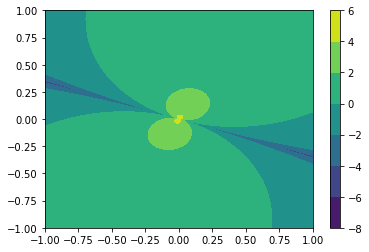

In [7]:
X, Y = np.meshgrid(np.linspace(-1, 1, num=200), np.linspace(-1, 1, num=200))

arg = np.stack((X, Y), axis=-1)
c = plt.contourf(X, Y, np.log(np.abs(Ahat(arg))))
plt.colorbar(c)
# estimated amplitude for the template xbar
# with varying xbar

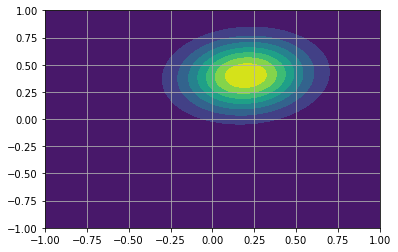

In [9]:


plt.contourf(X, Y, bivariate_posterior(5, arg))
plt.grid()

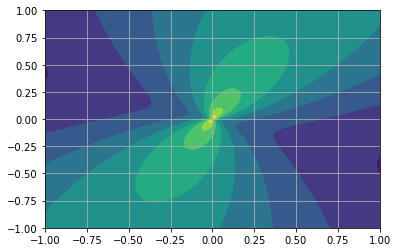

In [10]:
plt.contourf(X, Y, np.log(marginal_posterior(arg)))
plt.grid()
# definitely not a Gaussian!

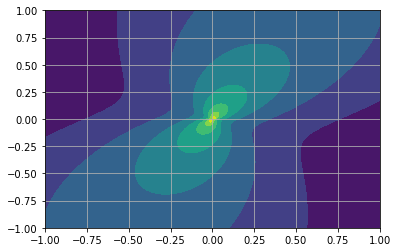

In [11]:
plt.contourf(X, Y, np.log(marginal_posterior_2(arg)))
plt.grid()

# cross-check: even numerical integration yields a similar result,
# slight discrepancies probably attributable to numerical error
# warning: computationally expensive